Natural Language Processing with Python – Analyzing Text with the Natural Language Toolkit Steven Bird, mEwan Klein, and Edward Loper http://www.nltk.org/book/

# Chapter 10 - Analyzing the Meaning of Sentences

## 10.1 Natural Language Understanding

### Querying a Database

In this section,we will show that solving the task in a restricted domain is pretty straightforward. But we will also see that to address the problem in a more general way, we have to open up a whole new box of ideas and techniques, involving the representation of meaning.

In [1]:
import nltk

In [2]:
nltk.data.show_cfg('grammars/book_grammars/sql0.fcfg')

% start S
S[SEM=(?np + WHERE + ?vp)] -> NP[SEM=?np] VP[SEM=?vp]
VP[SEM=(?v + ?pp)] -> IV[SEM=?v] PP[SEM=?pp]
VP[SEM=(?v + ?ap)] -> IV[SEM=?v] AP[SEM=?ap]
NP[SEM=(?det + ?n)] -> Det[SEM=?det] N[SEM=?n]
PP[SEM=(?p + ?np)] -> P[SEM=?p] NP[SEM=?np]
AP[SEM=?pp] -> A[SEM=?a] PP[SEM=?pp]
NP[SEM='Country="greece"'] -> 'Greece'
NP[SEM='Country="china"'] -> 'China'
Det[SEM='SELECT'] -> 'Which' | 'What'
N[SEM='City FROM city_table'] -> 'cities'
IV[SEM=''] -> 'are'
A[SEM=''] -> 'located'
P[SEM=''] -> 'in'


In [3]:
from nltk import load_parser


cp = load_parser('grammars/book_grammars/sql0.fcfg')
query = 'What cities are located in China'
trees = list(cp.parse(query.split()))
answer = trees[0].label()['SEM']
answer = [s for s in answer if s]
q = ' '.join(answer)
print(q)

SELECT City FROM city_table WHERE Country="china"


In [4]:
from nltk.sem import chat80


rows = chat80.sql_query('corpora/city_database/city.db', q)
for r in rows: print(r[0], end=" ")

canton chungking dairen harbin kowloon mukden peking shanghai sian tientsin 

In [5]:
nltk.data.show_cfg('grammars/book_grammars/sql1.fcfg')

% start S
S[SEM=(?np + WHERE + ?vp)] -> NP[SEM=?np] VP[SEM=?vp]
VP[SEM=(?v + ?pp)] -> IV[SEM=?v] PP[SEM=?pp]
VP[SEM=(?v + ?ap)] -> IV[SEM=?v] AP[SEM=?ap]
VP[SEM=(?v + ?np)] -> TV[SEM=?v] NP[SEM=?np]
VP[SEM=(?vp1 + ?c + ?vp2)] -> VP[SEM=?vp1] Conj[SEM=?c] VP[SEM=?vp2]
NP[SEM=(?det + ?n)] -> Det[SEM=?det] N[SEM=?n]
NP[SEM=(?n + ?pp)]  -> N[SEM=?n] PP[SEM=?pp]
NP[SEM=?n]  -> N[SEM=?n]  | CardN[SEM=?n] 
CardN[SEM='1000'] -> '1,000,000' 
PP[SEM=(?p + ?np)] -> P[SEM=?p] NP[SEM=?np]
AP[SEM=?pp] -> A[SEM=?a] PP[SEM=?pp]
NP[SEM='Country="greece"'] -> 'Greece'
NP[SEM='Country="china"'] -> 'China'
Det[SEM='SELECT'] -> 'Which' | 'What'
Conj[SEM='AND'] -> 'and'
N[SEM='City FROM city_table'] -> 'cities'
N[SEM='Population'] -> 'populations'
IV[SEM=''] -> 'are'
TV[SEM=''] -> 'have'
A -> 'located'
P[SEM=''] -> 'in'
P[SEM='>'] -> 'above'


In [6]:
cp = load_parser('grammars/book_grammars/sql1.fcfg')
query = 'What cities are in China and have populations above 1,000,000'
trees = list(cp.parse(query.split()))
answer = trees[0].label()['SEM']
answer = [s for s in answer if s]
q = ' '.join(answer)
print(q)

SELECT City FROM city_table WHERE Country="china" AND Population > 1000


In [7]:
rows = chat80.sql_query('corpora/city_database/city.db', q)
for r in rows: print(r[0], end=" ")

canton chungking mukden peking shanghai tientsin 

### Natural Language, Semantics and Logic

A **model** for a set W of sentences is a formal representation of a situation in which all the sentences in W are true. The usual way of representing models involves set theory. The domain D of discourse (all the entities we currently care about) is a set of individuals, while relations are treated as sets built up from D. Let's look at a concrete example. Our domain D will consist of three children, Stefan, Klaus and Evi, represented respectively as s, k and e. We write this as D = {s, k, e}. The expression boy denotes the set consisting of Stefan and Klaus, the expression girl denotes the set consisting of Evi, and the expression is running denotes the set consisting of Stefan and Evi. 1.2 is a graphical rendering of the model.

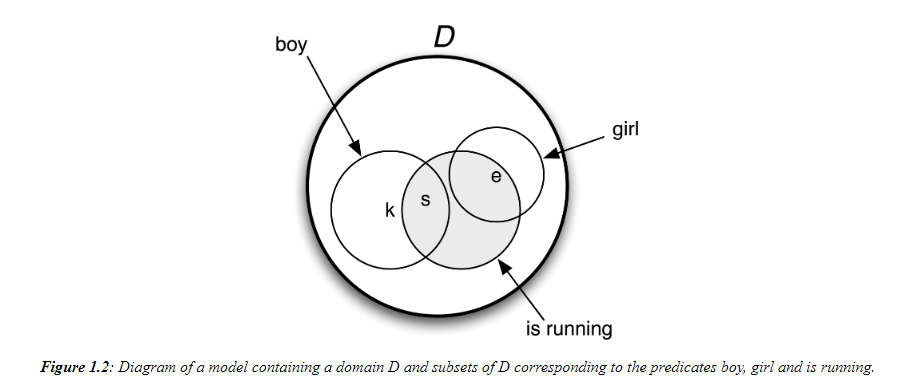

## 10.2 Propositional Logic

A logical language is designed to make reasoning formally explicit. As a result, it can capture aspects of natural language which determine whether a set of sentences is consistent. As part of this approach, we need to develop logical representations of a sentence φ that formally capture the truth-conditions of φ.

In [8]:
nltk.boolean_ops()

negation       	-
conjunction    	&
disjunction    	|
implication    	->
equivalence    	<->


In [9]:
read_expr = nltk.sem.Expression.fromstring

In [10]:
read_expr('-(P & Q)')

<NegatedExpression -(P & Q)>

In [11]:
read_expr('P & Q')

<AndExpression (P & Q)>

In [12]:
read_expr('P | (R -> Q)')

<OrExpression (P | (R -> Q))>

In [13]:
read_expr('P <-> -- P')

<IffExpression (P <-> --P)>

From a computational perspective, logics give us an important tool for performing inference. Suppose you state that Freedonia is not to the north of Sylvania, and you give as your reasons that Sylvania is to the north of Freedonia. In this case, you have produced an **argument**. The sentence Sylvania is to the north of Freedonia is the **assumption** of the argument while Freedonia is not to the north of Sylvania is the **conclusion**. The step of moving from one or more assumptions to a conclusion is called **inference**. Informally, it is common to write arguments in a format where the conclusion is preceded by therefore.

An argument is **valid** if there is no possible situation in which its premises are all true and its conclusion is not true.

Arguments can be tested for "syntactic validity" by using a proof system. We will say a little bit more about this later on in 3. Logical proofs can be carried out with NLTK's inference module, for example via an interface to the third-party theorem prover Prover9. The inputs to the inference mechanism first have to be converted into logical expressions.

In [14]:
read_expr = nltk.sem.Expression.fromstring
SnF = read_expr('SnF')
NotFnS = read_expr('-FnS')
R = read_expr('SnF -> -FnS')
prover = nltk.Prover9()
prover.prove(NotFnS, [SnF, R])

True

In [15]:
val = nltk.Valuation([('P', True), ('Q', True), ('R', False)])

In [16]:
val['P']

True

In [17]:
dom = set([])
g = nltk.Assignment(dom)

In [18]:
m = nltk.Model(dom, val)

In [19]:
print(m.evaluate('(P & Q)', g))

True


In [20]:
print(m.evaluate('-(P & Q)', g))

False


In [21]:
print(m.evaluate('(P & R)', g))

False


In [22]:
print(m.evaluate('(P | R)', g))

True


## 10.3 First-Order Logic

In the remainder of this chapter, we will represent the meaning of natural language expressions by translating them into first-order logic. Not all of natural language semantics can be expressed in first-order logic. But it is a good choice for computational semantics because it is expressive enough to represent many aspects of semantics, and on the other hand, there are excellent systems available off the shelf for carrying out automated inference in first-order logic.

### Syntax

First-order logic keeps all the Boolean operators of propositional logic, but it adds some important new mechanisms. To start with, propositions are analyzed into predicates and arguments, which takes us a step closer to the structure of natural languages. The standard construction rules for first-order logic recognize **terms** such as individual variables and individual constants, and **predicates** which take differing numbers of arguments. For example, *Angus walks* might be formalized as *walk(angus)* and *Angus sees Bertie* as *see(angus, bertie)*. We will call walk a **unary predicate**, and see a **binary predicate**.

We should mention here that one binary predicate has special status, namely **equality**, as in formulas such as *angus = aj*. Equality is regarded as a logical constant, since for individual terms *t1* and *t2*, the formula *t1 = t2* is true if and only if *t1* and *t2* refer to one and the same entity.

It is often helpful to inspect the syntactic structure of expressions of first-order logic, and the usual way of doing this is to assign **types** to expressions. Following the tradition of Montague grammar, we will use two **basic types**: *e* is the type of entities, while *t* is the type of formulas, i.e., expressions which have truth values. Given these two basic types, we can form **complex types** for function expressions. That is, given any types σ and τ, 〈σ, τ〉 is a complex type corresponding to functions from 'σ things' to 'τ things'. For example, 〈e, t〉 is the type of expressions from entities to truth values, namely unary predicates. The logical expression can be processed with type checking.

In [23]:
read_expr = nltk.sem.Expression.fromstring
expr = read_expr('walk(angus)', type_check=True)

In [24]:
expr.argument

<ConstantExpression angus>

In [25]:
expr.argument.type

e

In [26]:
expr.function

<ConstantExpression walk>

In [27]:
expr.function.type

<e,?>

Why do we see <e,?> at the end of this example? Although the type-checker will try to infer as many types as possible, in this case it has not managed to fully specify the type of walk, since its result type is unknown. Although we are intending walk to receive type <e, t>, as far as the type-checker knows, in this context it could be of some other type such as <e, e> or <e, <e, t>. To help the type-checker, we need to specify a **signature**, implemented as a dictionary that explicitly associates types with non-logical constants:

In [28]:
sig = {'walk': '<e, t>'}
expr = read_expr('walk(angus)', signature=sig)
expr.function.type

e

In general, an occurrence of a variable x in a formula φ is **free** in φ if that occurrence doesn't fall within the scope of all x or some x in φ. Conversely, if x is free in formula φ, then it is **bound** in all x.φ and exists x.φ. If all variable occurrences in a formula are bound, the formula is said to be **closed**.

In [29]:
read_expr = nltk.sem.Expression.fromstring

In [30]:
read_expr('dog(cyril)').free()

set()

In [31]:
read_expr('dog(x)').free()

{Variable('x')}

In [32]:
read_expr('own(angus, cyril)').free()

set()

In [33]:
read_expr('exists x.dog(x)').free()

set()

In [34]:
read_expr('((some x. walk(x)) -> sing(x))').free()

{Variable('x')}

In [35]:
read_expr('exists x.own(y, x)').free()

{Variable('y')}

### First-Order Theorem Proving

The general case in theorem proving is to determine whether a formula that we want to prove (a **proof goal**) can be derived by a finite sequence of inference steps from a list of assumed formulas. We write this as S ⊢ g, where S is a (possibly empty) list of assumptions, and g is a proof goal. 

In [36]:
NotFnS = read_expr('-north_of(f, s)')
SnF = read_expr('north_of(s, f)') 
R = read_expr('all x. all y. (north_of(x, y) -> -north_of(y, x))') 
prover = nltk.Prover9()
prover.prove(NotFnS, [SnF, R])

True

Happily, the theorem prover agrees with us that the argument is valid. By contrast, it concludes that it is not possible to infer north_of(f, s) from our assumptions:

In [37]:
FnS = read_expr('north_of(f, s)')
prover.prove(FnS, [SnF, R])

False

### Summarizing the Language of First Order Logic

We'll take this opportunity to restate our earlier syntactic rules for propositional logic and add the formation rules for quantifiers; together, these give us the syntax of first order logic. In addition, we make explicit the types of the expressions involved. We'll adopt the convention that 〈e^n, t〉 is the type of a predicate which combines with n arguments of type e to yield an expression of type t. In this case, we say that n is the **arity** of the predicate.

1. If P is a predicate of type 〈en, t〉, and α1, ... αn are terms of type e, then P(α1, ... αn) is of type t.
2. If α and β are both of type e, then (α = β) and (α != β) are of type t.
3. If φ is of type t, then so is -φ.
4. If φ and ψ are of type t, then so are (φ & ψ), (φ | ψ), (φ -> ψ) and (φ <-> ψ).
5. If φ is of type t, and x is a variable of type e, then exists x.φ and all x.φ are of type t.

The table below summarizes the new logical constants of the logic module, and two of the methods of Expressions.

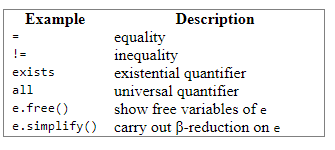

### Truth in Model

Given a first-order logic language L, a model M for L is a pair 〈D, Val〉, where D is an nonempty set called the **domain** of the model, and Val is a function called the **valuation function** which assigns values from D to expressions of L as follows:

1. For every individual constant c in L, Val(c) is an element of D.
2. For every predicate symbol P of arity n ≥ 0, Val(P) is a function from D^n to {True, False}. (If the arity of P is 0, then Val(P) is simply a truth value, the P is regarded as a propositional symbol.)

According to (ii), if P is of arity 2, then Val(P) will be a function f from pairs of elements of D to {True, False}. In the models we shall build in NLTK, we'll adopt a more convenient alternative, in which Val(P) is a set S of pairs, defined as follows S = {s | f(s) = True}.

Such an *f* is called the **characteristic function** of S (as discussed in the further readings).

Relations are represented semantically in NLTK in the standard set-theoretic way: as sets of tuples. For example, let’s suppose we have a domain of discourse consisting of the individuals Bertie, Olive, and Cyril, where Bertie is a boy, Olive is a girl, and Cyril is a dog. For mnemonic reasons, we use b, o and c as the corresponding labels in the model. We can declare the domain as follows:

In [38]:
dom = {'b', 'o', 'c'}

We will use the utility function Valuation.fromstring() to convert a list of strings of the form symbol => value into a Valuation object.

In [39]:
v = """
    bertie => b
    olive => o
    cyril => c
    boy => {b}
    girl => {o}
    dog => {c}
    walk => {o, c}
    see => {(b, o), (c, b), (o, c)}
"""

In [40]:
val = nltk.Valuation.fromstring(v)
val

{'bertie': 'b',
 'olive': 'o',
 'cyril': 'c',
 'boy': {('b',)},
 'girl': {('o',)},
 'dog': {('c',)},
 'walk': {('c',), ('o',)},
 'see': {('b', 'o'), ('c', 'b'), ('o', 'c')}}

So according to this valuation, the value of see is a set of tuples such that Bertie sees Olive, Cyril sees Bertie, and Olive sees Cyril. You may have noticed that our unary predicates (i.e, boy, girl, dog) also come out as sets of singleton tuples, rather than just sets of individuals. This is a convenience which allows us to have a uniform treatment of relations of any arity.

A predication of the form P(τ1, ... τn), where P is of arity n, comes out true just in case the tuple of values corresponding to (τ1, ... τn) belongs to the set of tuples in the value of P.

In [41]:
('o', 'c') in val['see']

True

In [42]:
('b',) in val['boy']

True

### Individual Variables and Assignments

In our models, the counterpart of a context of use is a variable **assignment**. This is a mapping from individual variables to entities in the domain. Assignments are created using the Assignment constructor, which also takes the model's domain of discourse as a parameter. We are not required to actually enter any bindings, but if we do, they are in a *(variable, value)* format similar to what we saw earlier for valuations.

In [43]:
g = nltk.Assignment(dom, [('x', 'o'), ('y', 'c')])
g

{'x': 'o', 'y': 'c'}

In addition, there is a print() format for assignments which uses a notation closer to that often found in logic textbooks:

In [44]:
print(g)

g[c/y][o/x]


Let's now look at how we can evaluate an atomic formula of first-order logic. First, we create a model, then we call the evaluate() method to compute the truth value.

In [45]:
m = nltk.Model(dom, val)
m.evaluate('see(olive, y)', g)

True

What's happening here? We are evaluating a formula which is similar to our earlier examplle, see(olive, cyril). However, when the interpretation function encounters the variable y, rather than checking for a value in val, it asks the variable assignment g to come up with a value:

In [46]:
g['y']

'c'

Since we already know that individuals o and c stand in the see relation, the value True is what we expected. In this case, we can say that assignment g **satisfies** the formula see(olive, y). By contrast, the following formula evaluates to False relative to g — check that you see why this is.

In [47]:
m.evaluate('see(y, x)', g)

False

In our approach (though not in standard first-order logic), variable assignments are *partial*. For example, g says nothing about any variables apart from x and y. The method purge() clears all bindings from an assignment.

In [48]:
g.purge()
g

{}

If we now try to evaluate a formula such as see(olive, y) relative to g, it is like trying to interpret a sentence containing a him when we don't know what him refers to. In this case, the evaluation function fails to deliver a truth value.

In [49]:
m.evaluate('see(olive, y)', g)

'Undefined'

Since our models already contain rules for interpreting boolean operators, arbitrarily complex formulas can be composed and evaluated.

In [50]:
m.evaluate('see(bertie, olive) & boy(bertie) & -walk(bertie)', g)

True

The general process of determining truth or falsity of a formula in a model is called **model checking**.

### Quantification

One of the crucial insights of modern logic is that the notion of variable satisfaction can be used to provide an interpretation for quantified formulas.

When is it true? Let's think about all the individuals in our domain, i.e., in dom. We want to check whether any of these individuals have the property of being a girl and walking. In other words, we want to know if there is some u in dom such that g[u/x] satisfies the open formula girl(x) & walk(x).

In [51]:
m.evaluate('exists x.(girl(x) & walk(x))', g)

True

evaluate() returns True here because there is some u in dom such that (25) is satisfied by an assignment which binds x to u. In fact, o is such a u:

In [52]:
m.evaluate('girl(x) & walk(x)', g.add('x', 'o'))

True

One useful tool offered by NLTK is the satisfiers() method. This returns a set of all the individuals that satisfy an open formula. The method parameters are a parsed formula, a variable, and an assignment. Here are a few examples:

In [53]:
g.purge()

In [54]:
fmla1 = read_expr('girl(x) | boy(x)')
m.satisfiers(fmla1, 'x', g)

{'b', 'o'}

In [55]:
fmla2 = read_expr('girl(x) -> walk(x)')
m.satisfiers(fmla2, 'x', g)

{'b', 'c', 'o'}

In [56]:
fmla3 = read_expr('walk(x) -> girl(x)')
m.satisfiers(fmla3, 'x', g)

{'b', 'o'}

It's useful to think about why fmla2 and fmla3 receive the values they do. The truth conditions for -> mean that fmla2 is equivalent to -girl(x) | walk(x), which is satisfied by something which either isn't a girl or walks. Since neither b (Bertie) nor c (Cyril) are girls, according to model m, they both satisfy the whole formula. And of course o satisfies the formula because o satisfies both disjuncts. Now, since every member of the domain of discourse satisfies fmla2, the corresponding universally quantified formula is also true.

In [57]:
m.evaluate('all x.(girl(x) -> walk(x))', g)

True

In other words, a universally quantified formula ∀x.φ is true with respect to g just in case for every u, φ is true with respect to g[u/x].

### Quantifier Scope Ambiguity

In [58]:
v2 = """
    bruce => b
    elspeth => e
    julia => j
    matthew => m
    person => {b, e, j, m}
    admire => {(j, b), (b, b), (m, e), (e, m)}
"""
val2 = nltk.Valuation.fromstring(v2)

In [59]:
dom2 = val2.domain
dom2

{'b', 'e', 'j', 'm'}

In [60]:
dom2 = val2.domain
m2 = nltk.Model(dom2, val2)
g2 = nltk.Assignment(dom2)
fmla4 = read_expr('(person(x) -> exists y.(person(y) & admire(x, y)))')
m2.satisfiers(fmla4, 'x', g2)

{'b', 'e', 'j', 'm'}

This shows that fmla4 holds of every individual in the domain. By contrast, consider the formula fmla5 below; this has no satisfiers for the variable y

In [61]:
fmla5 = read_expr('(person(y) & all x.(person(x) -> admire(x, y)))')
m2.satisfiers(fmla5, 'y', g2)

set()

That is, there is no person that is admired by everybody. Taking a different open formula, fmla6, we can verify that there is a person, namely Bruce, who is admired by both Julia and Bruce.

In [62]:
fmla6 = read_expr('(person(y) & all x.((x = bruce | x = julia) -> admire(x, y)))')
m2.satisfiers(fmla6, 'y', g2)

{'b'}

### Model Building

We have been assuming that we already had a model, and wanted to check the truth of a sentence in the model. By contrast, model building tries to create a new model, given some set of sentences. If it succeeds, then we know that the set is consistent, since we have an existence proof of the model.

We invoke the Mace4 model builder by creating an instance of Mace() and calling its build_model() method, in an analogous way to calling the Prover9 theorem prover. One option is to treat our candidate set of sentences as assumptions, while leaving the goal unspecified. The following interaction shows how both [a, c1] and [a, c2] are consistent lists, since Mace succeeds in building a model for each of them, while [c1, c2] is inconsistent.

In [63]:
a3 = read_expr('exists x.(man(x) & walks(x))')
c1 = read_expr('mortal(socrates)')
c2 = read_expr('-mortal(socrates)')
mb = nltk.Mace(5)
print(mb.build_model(None, [a3, c1]))
print(mb.build_model(None, [a3, c2]))
print(mb.build_model(None, [c1, c2]))

True
True
False


We can also use the model builder as an adjunct to the theorem prover. Let's suppose we are trying to prove S ⊢ g, i.e. that g is logically derivable from assumptions S = [s1, s2, ..., sn]. We can feed this same input to Mace4, and the model builder will try to find a counterexample, that is, to show that g does not follow from S. So, given this input, Mace4 will try to find a model for the set S together with the negation of g, namely the list S' =
[s1, s2, ..., sn, -g]. If g fails to follow from S, then Mace4 may well return with a counterexample faster than Prover9 concludes that it cannot find the required proof. Conversely, if g is provable from S, Mace4 may take a long time unsuccessfully trying to find a countermodel, and will eventually give up.

Let's consider a concrete scenario. Our assumptions are the list [*There is a woman that every man loves, Adam is a man, Eve is a woman*]. Our conclusion is Adam loves Eve. Can Mace4 find a model in which the premises are true but the conclusion is false? In the following code, we use MaceCommand() which will let us inspect the model that has been built.

In [64]:
a4 = read_expr('exists y. (woman(y) & all x. (man(x) -> love(x,y)))')
a5 = read_expr('man(adam)')
a6 = read_expr('woman(eve)')
g = read_expr('love(adam,eve)')
mc = nltk.MaceCommand(g, assumptions=[a4, a5, a6])
mc.build_model()

True

So the answer is Yes: Mace4 found a countermodel in which there is some woman other than Eve that Adam loves. But let's have a closer look at Mace4's model, converted to the format we use for valuations.

In [65]:
print(mc.valuation)

{'C1': 'b',
 'adam': 'a',
 'eve': 'a',
 'love': {('a', 'b')},
 'man': {('a',)},
 'woman': {('a',), ('b',)}}


The general form of this valuation should be familiar to you: it contains some individual constants and predicates, each with an appropriate kind of value. What might be puzzling is the C1. This is a "skolem constant" that the model builder introduces as a representative of the existential quantifier. That is, when the model builder encountered the exists y part of a4 above, it knew that there is some individual b in the domain which satisfies the open formula in the body of a4. However, it doesn't know whether b is also the denotation of an individual constant anywhere else in its input, so it makes up a new name for b on the fly, namely C1. Now, since our premises said nothing about the individual constants adam and eve, the model builder has decided there is no reason to treat them as denoting different entities, and they both get mapped to a. Moreover, we didn't specify that man and woman denote disjoint sets, so the model builder lets their denotations overlap. This illustrates quite dramatically the implicit knowledge that we bring to bear in interpreting our scenario, but which the model builder knows nothing about. So let's add a new assumption which makes the sets of men and women disjoint. The model builder still produces a countermodel, but this time it is more in accord with our intuitions about the situation:

In [66]:
a7 = read_expr('all x. (man(x) -> -woman(x))')
g = read_expr('love(adam,eve)')
mc = nltk.MaceCommand(g, assumptions=[a4, a5, a6, a7])
mc.build_model()

True

In [67]:
print(mc.valuation)

{'C1': 'c',
 'adam': 'a',
 'eve': 'b',
 'love': {('a', 'c')},
 'man': {('a',)},
 'woman': {('b',), ('c',)}}


On reflection, we can see that there is nothing in our premises which says that Eve is the only woman in the domain of discourse, so the countermodel in fact is acceptable. If we wanted to rule it out, we would have to add a further assumption such as exists y. all x. (woman(x) -> (x = y)) to ensure that there is only one woman in the model.

In [68]:
a8 = read_expr('exists y. all x. (woman(x) -> (x = y))')
g = read_expr('love(adam,eve)')
mc = nltk.MaceCommand(g, assumptions=[a4, a5, a6, a7, a8])
mc.build_model() # Mace4 may take a long time unsuccessfully trying to find a countermodel, and will eventually give up.

False

In [69]:
prover = nltk.Prover9()
prover.prove(g, assumptions=[a4, a5, a6, a7, a8])

True

## 10.4 The Semantics of English Sentences

### Compositional Semantics in Feature-Based Grammar

**Principle of Compositionality**: The meaning of a whole is a function of the meanings of the parts and of the way they are syntactically combined.

### The λ-Calculus

λ is a binding operator, just as the first-order logic quantifiers are. If we have an open formula such as (33a), then we can bind the variable x with the λ operator, as shown in (33b). The corresponding NLTK representation is given in (33c).

(33)		
a.		(walk(x) ∧ chew_gum(x))

b.		λx.(walk(x) ∧ chew_gum(x))

c.		\x.(walk(x) & chew_gum(x))

Remember that \ is a special character in Python strings. We could escape it (with another \), or else use "raw strings":

In [70]:
read_expr = nltk.sem.Expression.fromstring
expr = read_expr(r'\x.(walk(x) & chew_gum(x))')
expr

<LambdaExpression \x.(walk(x) & chew_gum(x))>

In [71]:
expr.free()

set()

In [72]:
print(read_expr(r'\x.(walk(x) & chew_gum(y))'))

\x.(walk(x) & chew_gum(y))


We have a special name for the result of binding the variables in an expression: λ abstraction. When you first encounter λ-abstracts, it can be hard to get an intuitive sense of their meaning. A couple of English glosses for (33b) are: "be an x such that x walks and x chews gum" or "have the property of walking and chewing gum". It has often been suggested that λ-abstracts are good representations for verb phrases (or subjectless clauses), particularly when these occur as arguments in their own right. This is illustrated in (34a) and its translation (34b).

(34)		
a.		To walk and chew-gum is hard

b.		hard(\x.(walk(x) & chew_gum(x)))

So the general picture is this: given an open formula φ with free variable x, abstracting over x yields a property expression λx.φ — the property of being an x such that φ. Here's a more official version of how abstracts are built:

(35)		If α is of type τ, and x is a variable of type e, then \x.α is of type 〈e, τ〉.

(34b) illustrated a case where we say something about a property, namely that it is hard. But what we usually do with properties is attribute them to individuals. And in fact if φ is an open formula, then the abstract λx.φ can be used as a unary predicate. In (36), (33b) is predicated of the term gerald.

(36)		\x.(walk(x) & chew_gum(x)) (gerald)

Now (36) says that Gerald has the property of walking and chewing gum, which has the same meaning as (37).

(37)		(walk(gerald) & chew_gum(gerald))

What we have done here is remove the \x from the beginning of \x.(walk(x) &
chew_gum(x)) and replaced all occurrences of x in (walk(x) &
chew_gum(x)) by gerald. We'll use α[β/x] as notation for the operation of replacing all free occurrences of x in α by the expression β. So:

(walk(x) & chew_gum(x))[gerald/x]

is the same expression as (37). The "reduction" of (36) to (37) is an extremely useful operation in simplifying semantic representations, and we shall use it a lot in the rest of this chapter. The operation is often called **β-reduction**. In order for it to be semantically justified, we want it to hold that λx. α(β) has the same semantic values as α[β/x]. This is indeed true, subject to a slight complication that we will come to shortly. In order to carry of β-reduction of expressions in NLTK, we can call the simplify() method:

In [73]:
expr = read_expr(r'\x.(walk(x) & chew_gum(x))(gerald)')
print(expr)

\x.(walk(x) & chew_gum(x))(gerald)


In [74]:
print(expr.simplify())

(walk(gerald) & chew_gum(gerald))


Although we have so far only considered cases where the body of the λ abstract is an open formula, i.e., of type t, this is not a necessary restriction; the body can be any well-formed expression. Here's an example with two λs.

(38)		\x.\y.(dog(x) & own(y, x))

Just as (33b) plays the role of a unary predicate, (38) works like a binary predicate: it can be applied directly to two arguments. Logical expressions may contain nested λs such as \x.\y. to be written in the abbreviated form \x y.

In [75]:
print(read_expr(r'\x.\y.(dog(x) & own(y, x))(cyril)').simplify())

\y.(dog(cyril) & own(y,cyril))


In [76]:
print(read_expr(r'\x y.(dog(x) & own(y, x))(cyril, angus)').simplify())

(dog(cyril) & own(angus,cyril))


All our λ abstracts so far have involved the familiar first order variables: x, y and so on — variables of type e. But suppose we want to treat one abstract, say \x.walk(x) as the argument of another λ abstract? We might try this:

\y.y(angus)(\x.walk(x))

But since the variable y is stipulated to be of type e, \y.y(angus) only applies to arguments of type e while \x.walk(x) is of type 〈e, t〉! Instead, we need to allow abstraction over variables of higher type. Let's use P and Q as variables of type 〈e, t〉, and then we can have an abstract such as \P.P(angus). Since P is of type 〈e, t〉, the whole abstract is of type 〈〈e, t〉, t〉. Then \P.P(angus)(\x.walk(x)) is legal, and can be simplified via β-reduction to \x.walk(x)(angus) and then again to walk(angus)

When carrying out β-reduction, some care has to be taken with variables. Consider, for example, the λ terms (39a) and (39b), which differ only in the identity of a free variable.

(39)		
a.		\y.see(y, x)

b.		\y.see(y, z)

Suppose now that we apply the λ-term \P.exists x.P(x) to each of these terms:

(40)		
a.		\P.exists x.P(x)(\y.see(y, x))

b.		\P.exists x.P(x)(\y.see(y, z))

We pointed out earlier that the results of the application should be semantically equivalent. But if we let the free variable x in (39a) fall inside the scope of the existential quantifier in (40a), then after reduction, the results will be different:

(41)		
a.		exists x.see(x, x)

b.		exists x.see(x, z)

(41a) means there is some x that sees him/herself, whereas (41b) means that there is some x that sees an unspecified individual z. What has gone wrong here? Clearly, we want to forbid the kind of variable "capture" shown in (41a).

In order to deal with this problem, let's step back a moment. Does it matter what particular name we use for the variable bound by the existential quantifier in the function expression of (40a)? The answer is No. In fact, given any variable-binding expression (involving ∀, ∃ or λ), the name chosen for the bound variable is completely arbitrary. For example, exists x.P(x) and exists y.P(y) are equivalent; they are called **α equivalents**, or **alphabetic variants**. The process of relabeling bound variables is known as **α-conversion**. When we test for equality of VariableBinderExpressions in the logic module (i.e., using ==), we are in fact testing for α-equivalence:

In [77]:
expr1 = read_expr('exists x.P(x)')
print(expr1)

exists x.P(x)


In [78]:
expr2 = expr1.alpha_convert(nltk.sem.Variable('z'))
print(expr2)

exists z.P(z)


In [79]:
expr1 == expr2

True

When β-reduction is carried out on an application f(a), we check whether there are free variables in a which also occur as bound variables in any subterms of f. Suppose, as in the example discussed above, that x is free in a, and that f contains the subterm exists x.P(x). In this case, we produce an alphabetic variant of exists x.P(x), say, exists z1.P(z1), and then carry on with the reduction. This relabeling is carried out automatically by the β-reduction code in logic, and the results can be seen in the following example.

In [80]:
expr3 = read_expr('\P.(exists x.P(x))(\y.see(y, x))')
print(expr3)

(\P.exists x.P(x))(\y.see(y,x))


In [85]:
print(expr3.simplify())

exists z5.see(z5,x)


As you work through examples like these in the following sections, you may find that the logical expressions which are returned have different variable names; for example you might see z14 in place of z1 in the above formula. This change in labeling is innocuous — in fact, it is just an illustration of alphabetic variants.

After this excursus, let's return to the task of building logical forms for English sentences.

### Quantified NPs

At the start of this section, we briefly described how to build a semantic representation for Cyril barks. You would be forgiven for thinking this was all too easy—surely there is a bit more to building compositional semantics.

### Transitive Verbs

In [86]:
read_expr = nltk.sem.Expression.fromstring
tvp = read_expr(r'\X x.X(\y.chase(x,y))')
np = read_expr(r'(\P.exists x.(dog(x) & P(x)))')
vp = nltk.sem.ApplicationExpression(tvp, np)
print(vp)
print(vp.simplify())

(\X x.X(\y.chase(x,y)))(\P.exists x.(dog(x) & P(x)))
\x.exists z6.(dog(z6) & chase(x,z6))


The grammar simple-sem.fcfg contains a small set of rules for parsing and translating simple examples of the kind that we have been looking at. Here's a slightly more complicated example.

In [87]:
from nltk import load_parser

parser = load_parser('grammars/book_grammars/simple-sem.fcfg', trace=0)
sentence = 'Angus gives a bone to every dog'
tokens = sentence.split()
for tree in parser.parse(tokens):
    print(tree.label()['SEM'])

all z8.(dog(z8) -> exists z7.(bone(z7) & give(angus,z7,z8)))


NLTK provides some utilities to make it easier to derive and inspect semantic interpretations. The function interpret_sents() is intended for interpretation of a list of input sentences. It builds a dictionary d where for each sentence sent in the input, d[sent] is a list of pairs *(synrep, semrep)* consisting of trees and semantic representations for sent. The value is a list since sent may be syntactically ambiguous; in the following example, however, there is only one parse tree per sentence in the list.

In [89]:
sents = ['Irene walks', 'Cyril bites an ankle']
grammar_file = 'grammars/book_grammars/simple-sem.fcfg'
for results in nltk.interpret_sents(sents, grammar_file):
    for (synrep, semrep) in results:
        print(synrep)
        print(semrep)
        print()

(S[SEM=<walk(irene)>]
  (NP[-LOC, NUM='sg', SEM=<\P.P(irene)>]
    (PropN[-LOC, NUM='sg', SEM=<\P.P(irene)>] Irene))
  (VP[NUM='sg', SEM=<\x.walk(x)>]
    (IV[NUM='sg', SEM=<\x.walk(x)>, TNS='pres'] walks)))
walk(irene)

(S[SEM=<exists z9.(ankle(z9) & bite(cyril,z9))>]
  (NP[-LOC, NUM='sg', SEM=<\P.P(cyril)>]
    (PropN[-LOC, NUM='sg', SEM=<\P.P(cyril)>] Cyril))
  (VP[NUM='sg', SEM=<\x.exists z9.(ankle(z9) & bite(x,z9))>]
    (TV[NUM='sg', SEM=<\X x.X(\y.bite(x,y))>, TNS='pres'] bites)
    (NP[NUM='sg', SEM=<\Q.exists x.(ankle(x) & Q(x))>]
      (Det[NUM='sg', SEM=<\P Q.exists x.(P(x) & Q(x))>] an)
      (Nom[NUM='sg', SEM=<\x.ankle(x)>]
        (N[NUM='sg', SEM=<\x.ankle(x)>] ankle)))))
exists z9.(ankle(z9) & bite(cyril,z9))



We have seen now how to convert English sentences into logical forms, and earlier we saw how logical forms could be checked as true or false in a model. Putting these two mappings together, we can check the truth value of English sentences in a given model. Let's take model m as defined above. The utility evaluate_sents() resembles interpret_sents() except that we need to pass a model and a variable assignment as parameters. The output is a triple *(synrep, semrep, value)* where *synrep, semrep* are as before, and *value* is a truth value. For simplicity, the following example only processes a single sentence.

In [90]:
v = """
    bertie => b
    olive => o
    cyril => c
    boy => {b}
    girl => {o}
    dog => {c}
    walk => {o, c}
    see => {(b, o), (c, b), (o, c)}
"""
val = nltk.Valuation.fromstring(v)
g = nltk.Assignment(val.domain)
m = nltk.Model(val.domain, val)
sent = 'Cyril sees every boy'
grammar_file = 'grammars/book_grammars/simple-sem.fcfg'
results = nltk.evaluate_sents([sent], grammar_file, m, g)[0]
for (syntree, semrep, value) in results:
    print(semrep)
    print(value)

all z10.(boy(z10) -> see(cyril,z10))
True


### Quantifier Ambiguity Revisited

One important limitation of the methods described earlier is that they do not deal with scope ambiguity.

In [91]:
from nltk.sem import cooper_storage as cs

In [92]:
sentence = 'every girl chases a dog'
trees = cs.parse_with_bindops(sentence, grammar='grammars/book_grammars/storage.fcfg')
semrep = trees[0].label()['SEM']
cs_semrep = cs.CooperStore(semrep)

In [93]:
print(cs_semrep.core)

chase(z2,z3)


In [94]:
for bo in cs_semrep.store:
    print(bo)

bo(\P.all x.(girl(x) -> P(x)),z2)
bo(\P.exists x.(dog(x) & P(x)),z3)


In [95]:
cs_semrep.s_retrieve(trace=True)

Permutation 1
   (\P.all x.(girl(x) -> P(x)))(\z2.chase(z2,z3))
   (\P.exists x.(dog(x) & P(x)))(\z3.all x.(girl(x) -> chase(x,z3)))
Permutation 2
   (\P.exists x.(dog(x) & P(x)))(\z3.chase(z2,z3))
   (\P.all x.(girl(x) -> P(x)))(\z2.exists x.(dog(x) & chase(z2,x)))


In [96]:
for reading in cs_semrep.readings:
    print(reading)

exists x.(dog(x) & all z13.(girl(z13) -> chase(z13,x)))
all x.(girl(x) -> exists z14.(dog(z14) & chase(x,z14)))


## 10.5 Discourse Semantics

A **discourse** is a sequence of sentences. Very often, the interpretation of a sentence in a discourse depends what preceded it. A clear example of this comes from anaphoric pronouns, such as he, she and it. Given discourse such as *Angus used to have a dog. But he recently disappeared.*, you will probably interpret *he* as referring to Angus's dog. However, in *Angus used to have a dog. He took him for walks in New Town.*, you are more likely to interpret *he* as referring to Angus himself.

### Discourse Representation Theory

The standard approach to quantification in first-order logic is limited to single sentences. Yet there seem to be examples where the scope of a quantifier can extend over two or more sentences. We saw one above, and here's a second example, together with a translation.

(54)		
a.		Angus owns a dog. It bit Irene.

b.		∃x.(dog(x) ∧ own(Angus, x) ∧ bite(x, Irene))

That is, the NP *a dog* acts like a quantifier which binds the *it* in the second sentence. Discourse Representation Theory (DRT) was developed with the specific goal of providing a means for handling this and other semantic phenomena which seem to be characteristic of discourse. A **discourse representation structure** (DRS) presents the meaning of discourse in terms of a list of discourse referents and a list of conditions. The **discourse referents** are the things under discussion in the discourse, and they correspond to the individual variables of first-order logic. The **DRS conditions** apply to those discourse referents, and correspond to atomic open formulas of first-order logic. 5.1 illustrates how DRS for the first sentence in (54a) is augmented to become a DRS for both sentences.

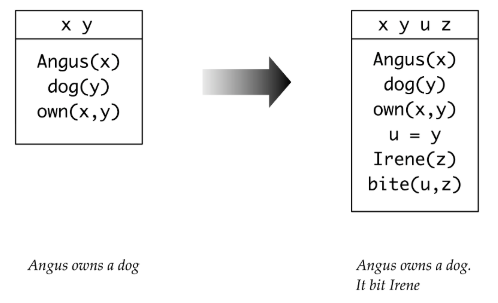

When the second sentence of (54a) is processed, it is interpreted in the context of what is already present in the left hand side of 5.1. The pronoun *it* triggers the addition of a new discourse referent, say *u*, and we need to find an **anaphoric antecedent** for it — that is, we want to work out what *it* refers to. In DRT, the task of finding the antecedent for an anaphoric pronoun involves linking it to a discourse referent already within the current DRS, and *y* is the obvious choice. (We will say more about anaphora resolution shortly.) This processing step gives rise to a new condition *u = y*. The remaining content contributed by the second sentence is also merged with the content of the first, and this is shown on the right hand side of 5.1.

5.1 illustrates how a DRS can represent more than just a single sentence. In this case, it is a two-sentence discourse, but in principle a single DRS could correspond to the interpretation of a whole text. We can inquire into the truth conditions of the right hand DRS in 5.1. Informally, it is true in some situation *s* if there are entities **a**, **c** and **i** in *s* corresponding to the discourse referents in the DRS such that all the conditions are true in *s* ; that is, **a** is named *Angus*, **c** is a dog, **a** owns **c**, **i** is named *Irene* and **c** bit **i**.

In order to process DRSs computationally, we need to convert them into a linear format. Here's an example, where the DRS is a pair consisting of a list of discourse of referents and a list of DRS conditions:

([x, y], [angus(x), dog(y), own(x,y)])

The easiest way to build a DRS object in NLTK is by parsing a string representation 

In [97]:
read_dexpr = nltk.sem.DrtExpression.fromstring
drs1 = read_dexpr('([x, y], [angus(x), dog(y), own(x, y)])')
print(drs1)

([x,y],[angus(x), dog(y), own(x,y)])


We can use the draw() method [1] to visualize the result, as shown in 5.2.

In [98]:
drs1.draw()

When we discussed the truth conditions of the DRSs in 5.1, we assumed that the topmost discourse referents were interpreted as existential quantifiers, while the conditions were interpreted as though they are conjoined. In fact, every DRS can be translated into a formula of first-order logic, and the fol() method implements this translation.

In [99]:
print(drs1.fol())

exists x y.(angus(x) & dog(y) & own(x,y))


In addition to the functionality available for first-order logic expressions, DRT Expressions have a DRS-concatenation operator, represented as the + symbol. The concatenation of two DRSs is a single DRS containing the merged discourse referents and the conditions from both arguments. DRS-concatenation automatically α-converts bound variables to avoid name-clashes.

In [100]:
drs2 = read_dexpr('([x], [walk(x)]) + ([y], [run(y)])')
print(drs2)
print(drs2.simplify())

(([x],[walk(x)]) + ([y],[run(y)]))
([x,y],[walk(x), run(y)])


While all the conditions seen so far have been atomic, it is possible to embed one DRS within another, and this is how universal quantification is handled. In drs3, there are no top-level discourse referents, and the sole condition is made up of two sub-DRSs, connected by an implication. Again, we can use fol() to get a handle on the truth conditions.

In [102]:
drs3 = read_dexpr('([], [(([x], [dog(x)]) -> ([y],[ankle(y), bite(x, y)]))])')
print(drs3.fol())

all x.(dog(x) -> exists y.(ankle(y) & bite(x,y)))


We pointed out earlier that DRT is designed to allow anaphoric pronouns to be interpreted by linking to existing discourse referents. DRT sets constraints on which discourse referents are "accessible" as possible antecedents, but is not intended to explain how a particular antecedent is chosen from the set of candidates. The module nltk.sem.drt_resolve_anaphora adopts a similarly conservative strategy: if the DRS contains a condition of the form PRO(x), the method resolve_anaphora() replaces this with a condition of the form x = [...], where [...] is a list of possible antecedents.

In [105]:
drs4 = read_dexpr('([x, y], [angus(x), dog(y), own(x, y)])')
drs5 = read_dexpr('([u, z], [PRO(u), irene(z), bite(u, z)])')
drs6 = drs4 + drs5
print(drs6.simplify())
print(drs6.simplify().resolve_anaphora())

([u,x,y,z],[angus(x), dog(y), own(x,y), PRO(u), irene(z), bite(u,z)])
([u,x,y,z],[angus(x), dog(y), own(x,y), (u = [x,y,z]), irene(z), bite(u,z)])


Since the algorithm for anaphora resolution has been separated into its own module, this facilitates swapping in alternative procedures which try to make more intelligent guesses about the correct antecedent.

Our treatment of DRSs is fully compatible with the existing machinery for handling λ abstraction, and consequently it is straightforward to build compositional semantic representations which are based on DRT rather than first-order logic. This technique is illustrated in the following rule for indefinites (which is part of the grammar drt.fcfg). For ease of comparison, we have added the parallel rule for indefinites from simple-sem.fcfg.

Det[num=sg,SEM=<\P Q.(([x],[]) + P(x) + Q(x))>] -> 'a'<div>
Det[num=sg,SEM=<\P Q. exists x.(P(x) & Q(x))>] -> 'a'

To get a better idea of how the DRT rule works, look at this subtree for the NP *a dog*.

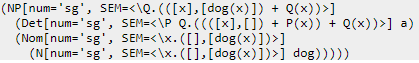

The λ abstract for the indefinite is applied as a function expression to \x.([],[dog(x)]) which leads to \Q.(([x],[]) + ([],[dog(x)]) +
Q(x)); after simplification, we get \Q.(([x],[dog(x)]) + Q(x)) as the representation for the NP as a whole.

In order to parse with grammar drt.fcfg, we specify in the call to load_parser() that SEM values in feature structures are to be parsed using DrtParser.

In [108]:
from nltk import load_parser

In [109]:
parser = load_parser('grammars/book_grammars/drt.fcfg', logic_parser=nltk.sem.drt.DrtParser())

In [118]:
for tree in parser.parse('Angus owns a dog'.split()):
    print(tree.label()['SEM'].simplify())

([x,z28],[Angus(x), dog(z28), own(x,z28)])


### Discourse Processing

When we interpret a sentence, we use a rich context for interpretation, determined in part by the preceding context and in part by our background assumptions.

In [ ]:
dt = nltk.DiscourseTester(['A student dances', 'Every student is a person'])

In [ ]:
dt.readings()

In [ ]:
dt.add_sentence('No person dances', consistchk=True)

In [ ]:
dt.retract_sentence('No person dances', verbose=True)

In [ ]:
dt.add_sentence('A person dances', informchk=True)

In [ ]:
from nltk.tag import RegexpTagger
tagger = RegexpTagger(
                    [('^(chases|runs)$', 'VB'),
                    ('^(a)$', 'ex_quant'),
                    ('^(every)$', 'univ_quant'),
                    ('^(dog|boy)$', 'NN'),
                    ('^(He)$', 'PRP')
                    ])

In [ ]:
rc = nltk.DrtGlueReadingCommand(depparser=nltk.MaltParser(tagger=tagger))

In [ ]:
dt = nltk.DiscourseTester(['Every dog chases a boy', 'He runs'], rc)

In [ ]:
dt.readings()

In [ ]:
dt.readings(show_thread_readings=True)

In [ ]:
dt.readings(show_thread_readings=True, filter=True)